# emotion detection

**importing libraries**

In [11]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


**Exploring Dataset**

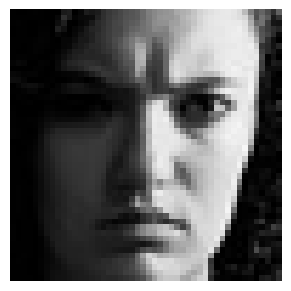

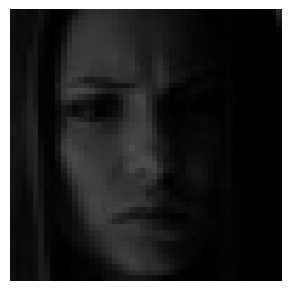

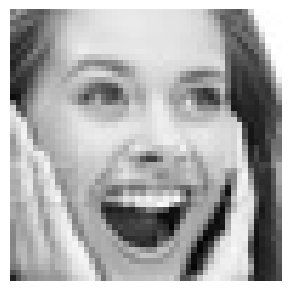

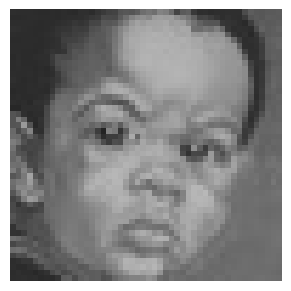

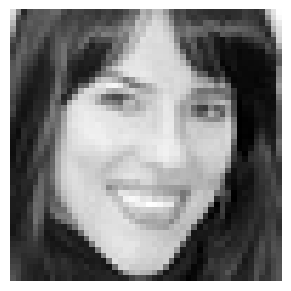

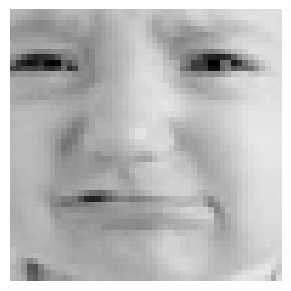

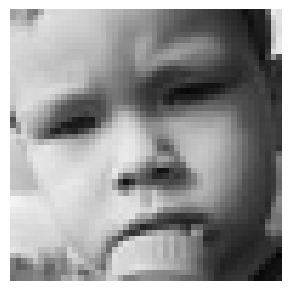

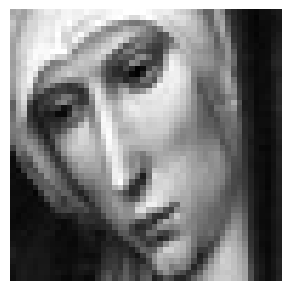

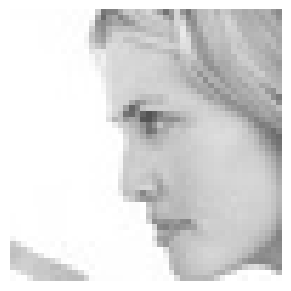

In [12]:
images = glob("/kaggle/input/fer2013/train/**/**")

for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')
    

**preparing data for traning**

In [14]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)




Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [15]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

In [16]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model


In [17]:
model = model_fer((48,48,1))
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0   

**Initializing the Model**

In [18]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

# Traning the Model

**The next cell takes time to complete**

In [19]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15


2023-10-05 05:28:38.600013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 1.6450 - accuracy: 0.3760
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 117s 252ms/step - loss: 1.6450 - accuracy: 0.3760 - val_loss: 1.4322 - val_accuracy: 0.4503
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3716 - accuracy: 0.4760
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 55s 122ms/step - loss: 1.3716 - accuracy: 0.4760 - val_loss: 1.3283 - val_accuracy: 0.4925
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2659 - accuracy: 0.5209
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 55s 123ms/step - loss: 1.2659 - accuracy: 0.5209 - val_loss: 1.3449 - val_accuracy: 0.4951
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.1911 - accuracy: 0.5487
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 64s 143ms/ste

In [20]:
model.evaluate(validation_generator)

113/113 [==============================] - 11s 97ms/step - loss: 1.0922 - accuracy: 0.6131


[1.0921999216079712, 0.6131234169006348]

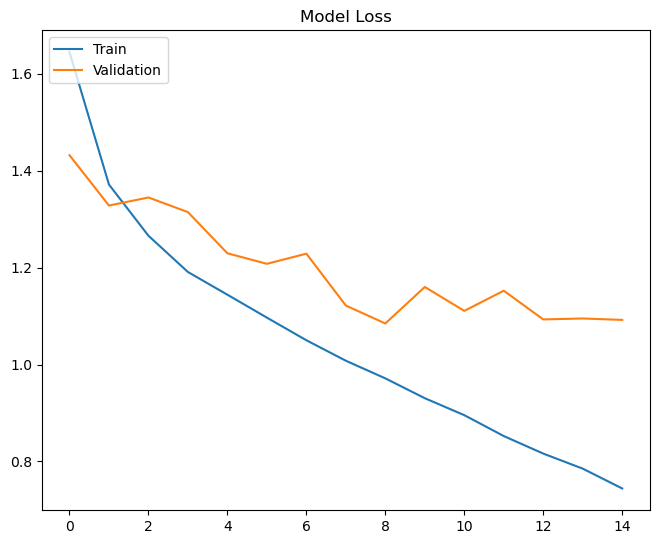

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

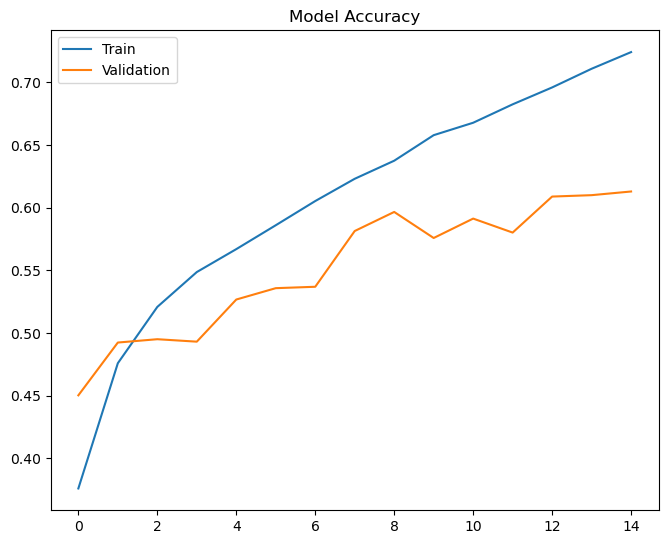

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)


In [23]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)